In [75]:
import cupy as cp 
import numpy as np
import matplotlib.pyplot as plt
import time as t


n = 3000
nt = 100
dt = 0.01
T = nt * dt
A = 1

t0 = t.perf_counter()
trajs = cp.random.normal(size=(n, nt+1))
trajs = cp.cumsum(trajs, axis=1)
t1 = t.perf_counter()
trajs = (trajs).get()
#Make the nt+1 value = NaN
min_val = np.min(trajs)
max_val = np.max(trajs)
trajs[:, -1] = np.nan


In [76]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.datatypes import RaggedArray
from matplotlib import colors

In [ ]:
# Optional colormaps
try:
    import colorcet as cc
    DENSITY_CMAP = cc.blues  
except Exception:
    DENSITY_CMAP = "Blues"


def render_density_plus_overlay(
    data: np.ndarray,
    dt: float,
    n: int,
    nt: int,
    out_png="all_trajectories_overlay.png",
    plot_width=1400,
    plot_height=800,
    background="black",
    overlay_n=150,           # how many individual trajectories to draw on top
    overlay_seed=0,
    overlay_alpha=220,       # 0..255 (higher = more visible)
):
    n, nt = data.shape
    t = np.arange(nt, dtype=np.float32) * dt

    x_range = (0, dt*nt)
    y_range = (float(np.nanmin(data)), float(np.nanmax(data)))

    cvs = ds.Canvas(
        plot_width=plot_width,
        plot_height=plot_height,
        x_range=x_range,
        y_range=y_range,
    )

    df_all = pd.DataFrame({
        "time": np.tile(t, n),
        "val":  data.reshape(-1),
        "id":   np.repeat(np.arange(n), nt),
    })
    
    
    agg_all = cvs.line(df_all, x="time", y="val", agg=ds.count())

    img_density = tf.shade(agg_all, cmap=DENSITY_CMAP, how="eq_hist")
    img_density = tf.set_background(img_density, background)

    rng = np.random.default_rng(overlay_seed)
    overlay_n = min(overlay_n, n)*0

    agg_overlay = cvs.line(df_all, x="time", y="val", agg=ds.count())
    img_overlay = tf.shade(agg_overlay, cmap=["#AEEBFF"], how="linear")
    img_overlay = tf.set_background(img_overlay, background)

    img_overlay = tf.dynspread(img_overlay, threshold=0.5, max_px=2)
    img = tf.stack(img_density, img_overlay)

    export_image(img, out_png.replace(".png", ""), fmt=".png")
    return img


if __name__ == "__main__":

    meta, data = {"n": n, "nt": nt, "dt": dt, "T": T}, trajs

    print("Loaded:", meta, "data shape:", data.shape)

    render_density_plus_overlay(
        data,
        dt=meta["dt"],
        n=n,
        nt=nt,
        out_png="all_trajectories_overlay.png",
        plot_width=1600,
        plot_height=900,
        overlay_n=200,     
        overlay_seed=1,
    )
    print("Wrote all_trajectories_overlay.png")

Loaded: {'n': 3000, 'nt': 100, 'dt': 0.01, 'T': 1.0} data shape: (3000, 101)
Wrote all_trajectories_overlay.png


In [80]:
def show_with_time_axis(img, t_min, t_max, y_min, y_max, xlabel="Time", ylabel="Value",):
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
   
    ax.imshow(
        img.to_pil(),
        extent=[t_min, t_max, y_min, y_max],
        origin="lower",
        aspect="auto",
    )
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_facecolor("black")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.patch.set_facecolor("black")

    plt.tight_layout()
    plt.show()

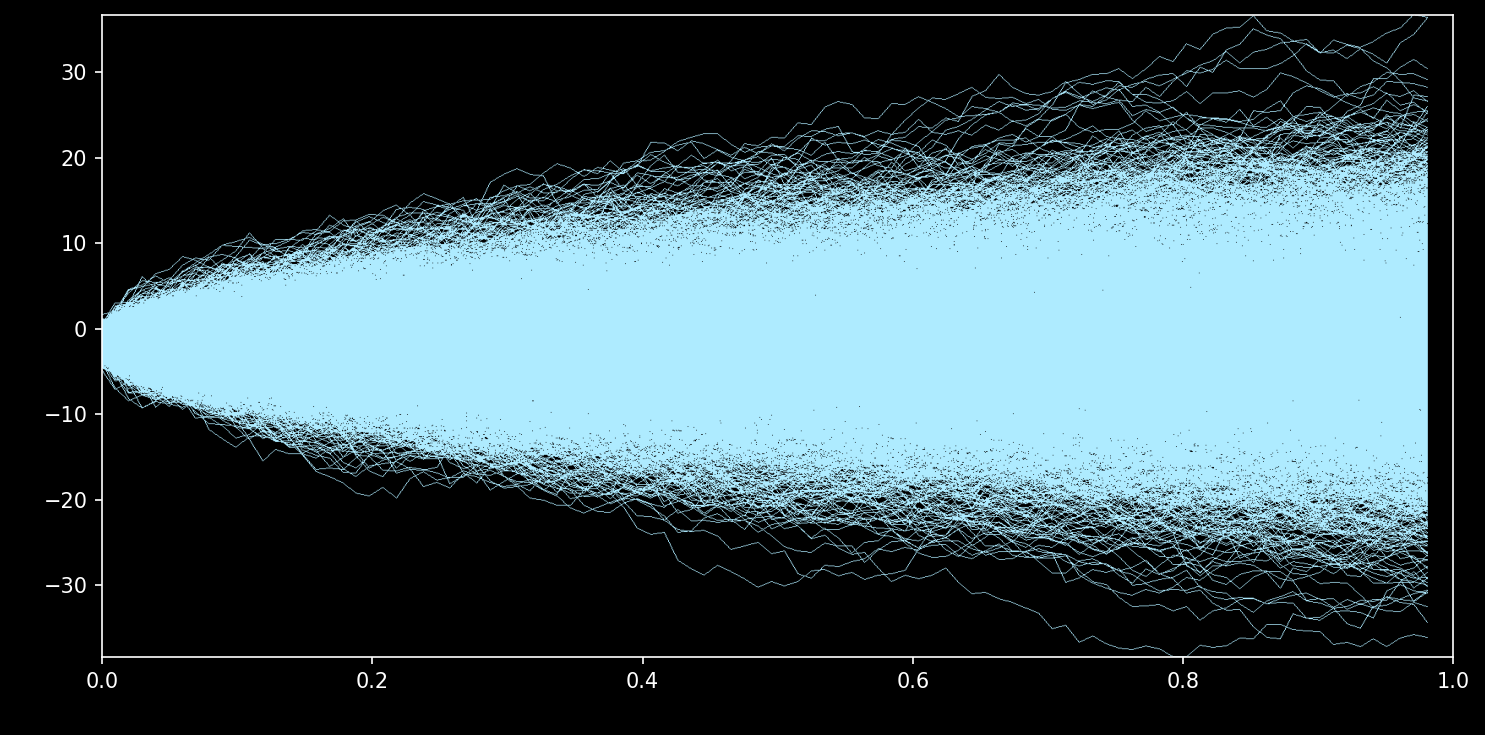

In [81]:
t_min = 0.0
t_max = meta["dt"] * (meta["nt"] - 1)
y_min = np.min(data)
y_max = np.max(data)
img = render_density_plus_overlay(
    data,
    dt=meta["dt"],
    n=n,
    nt=nt,
    out_png="all_trajectories_overlay.png",
    plot_width=1600,
    plot_height=900,
    overlay_n=200,
    overlay_seed=1,
)

show_with_time_axis(
    img,
    t_min=t_min,
    t_max=T,
    y_min=min_val,
    y_max=max_val,
    xlabel="Time",
    ylabel="Particle value",
)